<a href="https://colab.research.google.com/github/Manjuphoenix/ML_team_buzz/blob/michelle/V2_omato_dataset_improved_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from collections import Counter

from PIL import Image

import torch
import torchvision
from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler, ConcatDataset



from sklearn.model_selection import train_test_split
from tqdm import tqdm


torch.cuda.empty_cache()

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

!pip install kaggle

from google.colab import files 
files.upload()

#Make a directory named kaggle and copy the kaggle.json file there; and change its permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#imagenet_data = torchvision.datasets.ImageNet('https://kaggle.com/saroz014/plant-diseases')
#data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=4, shuffle=True, num_workers=args.nThreads)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d manjuphoenix/tomatodataset

 98% 902M/923M [00:06<00:00, 185MB/s]
100% 923M/923M [00:06<00:00, 151MB/s]


In [5]:
from zipfile import ZipFile
file_name = 'tomatodataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
])


device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
# Uncomment the below line based on where you train the model----------------------------------------
# !mkdir /kaggle/working/Tomato

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

# !rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
# !rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus 

# Uncomment this for training on kaggle
# data = datasets.ImageFolder('/kaggle/working/Tomato', transform=transform)----------------------------


# This is for training on Local Machine
data = datasets.ImageFolder('/content/Tomato', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.7)
train_set, test_set = random_split(data, [train_len, len(data) - train_len])

# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(val_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)
# x, y = next(iter(dataloaders[0]))

cuda:0
The total number of images is: 2841
The number of images in a training set is: 90912
The number of images in a test set is: 19488
Dataset ImageFolder
    Number of datapoints: 64936
    Root location: /content/Tomato
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']


In [7]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.LeakyReLU()
#         self.mish1 = nn.Mish()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=2)
        self.relu2 = nn.LeakyReLU()
#         self.mish2 = nn.Mish()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
#         self.cnn3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2)
#         self.relu3 = nn.ReLU()
#         self.mish2 = nn.Mish()
#         self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(8*65*65, 1000)
        self.fc2 = nn.Linear(1000, 8)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
#         out = self.mish1(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
#         out = self.mish2(out)
        out = self.maxpool2(out)
#         out = self.cnn3(out)
#         out = self.relu3(out)
#         out = self.maxpool3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
model = NeuralNetwork()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0003
optimizer_ft = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [8]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  if accuracy >= 95.:
    print('Model trained to 95% accuracy!')
  else:
    accuracies['train'].append(accuracy)
    losses['train'].append(loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [9]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [11]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

# optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5, momentum=0.6)

In [ ]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=100
for epoch in range(1,int(epochs)+1):
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)
  


Epoch : 1


100%|██████████| 2841/2841 [08:33<00:00,  5.53it/s]


Train Loss: 0.917 | Accuracy: 66.481


100%|██████████| 609/609 [01:45<00:00,  5.79it/s]


Test Loss: 0.695 | Accuracy: 74.606

Epoch : 2


100%|██████████| 2841/2841 [08:23<00:00,  5.65it/s]


Train Loss: 0.676 | Accuracy: 75.248


100%|██████████| 609/609 [01:44<00:00,  5.81it/s]


Test Loss: 0.702 | Accuracy: 74.021

Epoch : 3


100%|██████████| 2841/2841 [08:28<00:00,  5.59it/s]


Train Loss: 0.612 | Accuracy: 77.602


100%|██████████| 609/609 [01:42<00:00,  5.93it/s]


Test Loss: 0.644 | Accuracy: 77.198

Epoch : 4


100%|██████████| 2841/2841 [08:25<00:00,  5.62it/s]


Train Loss: 0.588 | Accuracy: 78.491


100%|██████████| 609/609 [01:44<00:00,  5.84it/s]


Test Loss: 0.616 | Accuracy: 77.773

Epoch : 5


100%|██████████| 2841/2841 [08:30<00:00,  5.57it/s]


Train Loss: 0.553 | Accuracy: 79.693


100%|██████████| 609/609 [01:42<00:00,  5.93it/s]


Test Loss: 0.585 | Accuracy: 78.702

Epoch : 6


100%|██████████| 2841/2841 [08:25<00:00,  5.62it/s]


Train Loss: 0.532 | Accuracy: 80.428


100%|██████████| 609/609 [01:41<00:00,  5.99it/s]


Test Loss: 0.569 | Accuracy: 79.421

Epoch : 7


100%|██████████| 2841/2841 [08:25<00:00,  5.63it/s]


Train Loss: 0.512 | Accuracy: 81.278


100%|██████████| 609/609 [01:44<00:00,  5.84it/s]


Test Loss: 0.533 | Accuracy: 80.638

Epoch : 8


100%|██████████| 2841/2841 [08:30<00:00,  5.57it/s]


Train Loss: 0.493 | Accuracy: 81.918


100%|██████████| 609/609 [01:44<00:00,  5.82it/s]


Test Loss: 0.474 | Accuracy: 82.321

Epoch : 9


100%|██████████| 2841/2841 [08:29<00:00,  5.57it/s]


Train Loss: 0.475 | Accuracy: 82.655


100%|██████████| 609/609 [01:43<00:00,  5.86it/s]


Test Loss: 0.454 | Accuracy: 83.764

Epoch : 10


100%|██████████| 2841/2841 [08:27<00:00,  5.60it/s]


Train Loss: 0.464 | Accuracy: 82.909


100%|██████████| 609/609 [01:41<00:00,  6.01it/s]


Test Loss: 0.522 | Accuracy: 81.823

Epoch : 11


100%|██████████| 2841/2841 [08:29<00:00,  5.58it/s]


Train Loss: 0.447 | Accuracy: 83.538


100%|██████████| 609/609 [01:44<00:00,  5.83it/s]


Test Loss: 0.443 | Accuracy: 83.974

Epoch : 12


100%|██████████| 2841/2841 [08:33<00:00,  5.53it/s]


Train Loss: 0.440 | Accuracy: 83.917


100%|██████████| 609/609 [01:42<00:00,  5.94it/s]


Test Loss: 0.434 | Accuracy: 84.344

Epoch : 13


100%|██████████| 2841/2841 [08:29<00:00,  5.58it/s]


Train Loss: 0.426 | Accuracy: 84.392


100%|██████████| 609/609 [01:43<00:00,  5.88it/s]


Test Loss: 0.528 | Accuracy: 80.848

Epoch : 14


100%|██████████| 2841/2841 [08:27<00:00,  5.59it/s]


Train Loss: 0.415 | Accuracy: 84.792


100%|██████████| 609/609 [01:43<00:00,  5.88it/s]


Test Loss: 0.432 | Accuracy: 84.534

Epoch : 15


100%|██████████| 2841/2841 [08:26<00:00,  5.61it/s]


Train Loss: 0.414 | Accuracy: 84.751


100%|██████████| 609/609 [01:41<00:00,  5.97it/s]


Test Loss: 0.458 | Accuracy: 83.158

Epoch : 16


100%|██████████| 2841/2841 [08:28<00:00,  5.59it/s]


Train Loss: 0.404 | Accuracy: 85.295


100%|██████████| 609/609 [01:45<00:00,  5.79it/s]


Test Loss: 0.392 | Accuracy: 85.863

Epoch : 17


100%|██████████| 2841/2841 [08:32<00:00,  5.54it/s]


Train Loss: 0.387 | Accuracy: 85.931


100%|██████████| 609/609 [01:44<00:00,  5.85it/s]


Test Loss: 0.417 | Accuracy: 85.447

Epoch : 18


100%|██████████| 2841/2841 [08:24<00:00,  5.63it/s]


Train Loss: 0.387 | Accuracy: 85.772


100%|██████████| 609/609 [01:44<00:00,  5.82it/s]


Test Loss: 0.435 | Accuracy: 84.144

Epoch : 19


100%|██████████| 2841/2841 [08:31<00:00,  5.56it/s]


Train Loss: 0.380 | Accuracy: 86.180


100%|██████████| 609/609 [01:45<00:00,  5.80it/s]


Test Loss: 0.388 | Accuracy: 85.879

Epoch : 20


100%|██████████| 2841/2841 [08:28<00:00,  5.59it/s]


Train Loss: 0.374 | Accuracy: 86.285


100%|██████████| 609/609 [01:45<00:00,  5.78it/s]


Test Loss: 0.380 | Accuracy: 86.058

Epoch : 21


100%|██████████| 2841/2841 [08:26<00:00,  5.61it/s]


Train Loss: 0.364 | Accuracy: 86.787


100%|██████████| 609/609 [01:43<00:00,  5.90it/s]


Test Loss: 0.377 | Accuracy: 86.453

Epoch : 22


100%|██████████| 2841/2841 [08:30<00:00,  5.57it/s]


Train Loss: 0.364 | Accuracy: 86.761


100%|██████████| 609/609 [01:45<00:00,  5.77it/s]


Test Loss: 0.374 | Accuracy: 86.438

Epoch : 23


 27%|██▋       | 777/2841 [02:18<05:50,  5.89it/s]

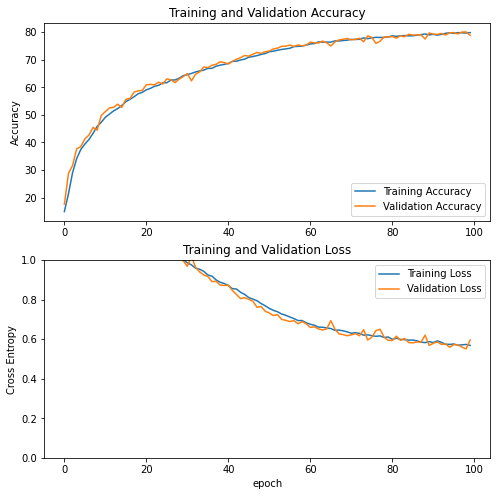

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Testing classification accuracy for individual classes.
classes = ['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
c = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

torch.cuda.BoolTensor
Accuracy of Tomato_Target_spot : 80 %
Accuracy of Tomato__Late_blight : 64 %
Accuracy of Tomato__Septoria_leaf_spot : 85 %
Accuracy of Tomato__Spider_mites : 74 %
Accuracy of Tomato___Bacterial_spot : 91 %
Accuracy of Tomato___Tomato_Yellow_Leaf_Curl_Virus : 85 %
Accuracy of Tomato__early_blight : 55 %
Accuracy of Tomato__healthy : 93 %


In [ ]:
avg = 0
for i in range(8):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/8
print('Average accuracy = ', avg)

Average accuracy =  78.88930759484418


In [ ]:
# Replace the paths accordingly!!

torch.save(model, 'v1_tomoato.pt')
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('v1_tomoato.pth') # Save

import os 
from IPython.display import FileLink
FileLink(r'v1_tomoato.pth')

import os 
from IPython.display import FileLink
FileLink(r'v1_tomoato.pt')

/content/v1_tomoato.pt

In [ ]:
# !pip install playsound

# from playsound import playsound
  
# # for playing note.wav file
# playsound('/path/note.wav')
# print('playing sound using  playsound')

In [ ]:
# import os, os.path

# # simple version for working with CWD
# print len([name for name in os.listdir('') if os.path.isfile(name)])

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/CornModelV1.pk1')

In [ ]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('CornModelV1.pt') # Save

import os 
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'CornModelV1.pt')

import os 
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'CornModelV1.pk1')

In [ ]:
import numpy
import matplotlib.pyplot as plt
import PIL.Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torch.utils.data import DataLoader

In [ ]:
!mkdir /kaggle/working/Tomato

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

!rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
!rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus

In [ ]:
def image_show(img, transform):
    plt.imshow(img.permute(1, 2, 0))

In [ ]:
print(device)


transform = transforms.Compose(
  [transforms.ToTensor(),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(),
    transforms.RandomInvert(),
    transforms.RandomRotation(30),]
)

cuda:0


In [ ]:
def train_val_split(dataset, val_split=0.25):
    train_index, val_index = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_index)
    datasets['val'] = Subset(dataset, val_index)
    return datasets

dataset = ImageFolder('/kaggle/working/Tomato', transform= transform)
# To Print the total number of image files
print(len(dataset))
datasets = train_val_split(dataset)
# To Print only the number of training set image files
print(len(datasets['train']))
#To Print the total number of Validataion image files
print(len(dataset[1]))

print(datasets['train'].dataset)

dataloaders = {x:DataLoader(datasets[x], 32, shuffle=True, num_workers=2) for x in ['train', 'val']}
x, y = next(iter(dataloaders['train']))


train_loader = torch.utils.data.DataLoader(datasets['train'], batch_size=32, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(datasets['val'], batch_size=32, shuffle=False, num_workers=2)

train_x, train_y = next(iter(train_loader))

val_x, val_y = next(iter(val_loader))



print("Train and Val loaders shape")
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)
print(train_x.size, train_y.size, val_x.size, val_y.size)
#This gives output 32 color images of 200 x 200 px image size as x.shape and 32 class labels as y.shape
print(x.shape, y.shape)

67332
50499
2
Dataset ImageFolder
    Number of datapoints: 67332
    Root location: /kaggle/working/Tomato
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               RandomGrayscale(p=0.1)
               RandomInvert(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
Train and Val loaders shape
torch.Size([32, 3, 256, 256]) torch.Size([32])
torch.Size([32, 3, 256, 256]) torch.Size([32])
<built-in method size of Tensor object at 0x7f3eac0c5770> <built-in method size of Tensor object at 0x7f3eac0c5830> <built-in method size of Tensor object at 0x7f3eac0c54d0> <built-in method size of Tensor object at 0x7f3eac0c51d0>
torch.Size([32, 3, 256, 256]) torch.Size([32])


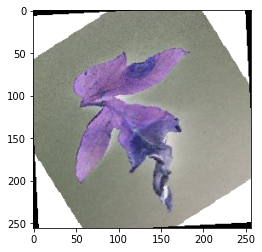

In [ ]:
image_show(x[1], transform)

In [ ]:
batch_size = 32
n_iters = 200000
num_epochs = int(n_iters / (len(datasets['train']) /batch_size))
print(num_epochs)

126


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(8*64*64, 8)
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
model = NeuralNetwork()

model = model.to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from tqdm import tqdm

# def train(model, loss_fn, dataloader, optimizer, epoch):
#     total_loss = 0
#     correct = 0
#     total = 0
#     model.train()
# #     TQDM is to make the terminal a progress bar
#     for data in tqdm(dataloader):
#         inputs, labels = data[0].to(device), data[1].to(device)
#         outputs = model(inputs)
#         loss = loss_fn(outputs, labels)
#         optimizer.step()
#         total_loss += loss.item()
#         _, predicted = outputs.max(1)
#         total += labels.size(0)
#         correct = predicted.eq(labels).sum().item()
        
#     loss  = total_loss/len(dataloader)
#     accuracy = 100.*correct/total
    
#     accuracies['train'].append(accuracy)
#     losses['train'].append(loss)
#     print('Train loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [ ]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [ ]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=30
for epoch in range(1,epochs+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


Epoch : 1


100%|██████████| 1579/1579 [06:58<00:00,  3.78it/s]


Train Loss: 1.466 | Accuracy: 46.118


100%|██████████| 527/527 [02:15<00:00,  3.89it/s]


Test Loss: 1.532 | Accuracy: 47.508

Epoch : 2


100%|██████████| 1579/1579 [06:57<00:00,  3.78it/s]


Train Loss: 1.211 | Accuracy: 56.863


100%|██████████| 527/527 [02:13<00:00,  3.94it/s]


Test Loss: 1.129 | Accuracy: 60.494

Epoch : 3


100%|██████████| 1579/1579 [06:48<00:00,  3.86it/s]


Train Loss: 1.126 | Accuracy: 60.340


100%|██████████| 527/527 [02:13<00:00,  3.95it/s]


Test Loss: 1.093 | Accuracy: 61.421

Epoch : 4


100%|██████████| 1579/1579 [06:55<00:00,  3.80it/s]


Train Loss: 1.049 | Accuracy: 62.817


100%|██████████| 527/527 [02:14<00:00,  3.92it/s]


Test Loss: 1.091 | Accuracy: 61.005

Epoch : 5


100%|██████████| 1579/1579 [06:52<00:00,  3.83it/s]


Train Loss: 0.968 | Accuracy: 65.738


100%|██████████| 527/527 [02:12<00:00,  3.96it/s]


Test Loss: 0.946 | Accuracy: 66.215

Epoch : 6


100%|██████████| 1579/1579 [06:49<00:00,  3.86it/s]


Train Loss: 0.907 | Accuracy: 68.195


100%|██████████| 527/527 [02:12<00:00,  3.99it/s]


Test Loss: 0.821 | Accuracy: 71.170

Epoch : 7


100%|██████████| 1579/1579 [06:49<00:00,  3.85it/s]


Train Loss: 0.857 | Accuracy: 70.009


100%|██████████| 527/527 [02:13<00:00,  3.95it/s]


Test Loss: 0.986 | Accuracy: 65.015

Epoch : 8


100%|██████████| 1579/1579 [06:51<00:00,  3.84it/s]


Train Loss: 0.821 | Accuracy: 71.415


100%|██████████| 527/527 [02:13<00:00,  3.94it/s]


Test Loss: 0.780 | Accuracy: 73.172

Epoch : 9


100%|██████████| 1579/1579 [06:47<00:00,  3.87it/s]


Train Loss: 0.801 | Accuracy: 72.243


100%|██████████| 527/527 [02:13<00:00,  3.96it/s]


Test Loss: 0.802 | Accuracy: 72.447

Epoch : 10


100%|██████████| 1579/1579 [06:49<00:00,  3.86it/s]


Train Loss: 0.789 | Accuracy: 72.552


100%|██████████| 527/527 [02:13<00:00,  3.94it/s]


Test Loss: 0.737 | Accuracy: 74.283

Epoch : 11


100%|██████████| 1579/1579 [06:48<00:00,  3.86it/s]


Train Loss: 0.775 | Accuracy: 73.138


100%|██████████| 527/527 [02:13<00:00,  3.95it/s]


Test Loss: 0.803 | Accuracy: 72.310

Epoch : 12


100%|██████████| 1579/1579 [06:49<00:00,  3.86it/s]


Train Loss: 0.751 | Accuracy: 73.990


100%|██████████| 527/527 [02:12<00:00,  3.98it/s]


Test Loss: 0.834 | Accuracy: 72.548

Epoch : 13


100%|██████████| 1579/1579 [06:48<00:00,  3.86it/s]


Train Loss: 0.752 | Accuracy: 73.879


100%|██████████| 527/527 [02:12<00:00,  3.97it/s]


Test Loss: 0.686 | Accuracy: 76.047

Epoch : 14


100%|██████████| 1579/1579 [06:50<00:00,  3.85it/s]


Train Loss: 0.728 | Accuracy: 74.611


100%|██████████| 527/527 [02:13<00:00,  3.96it/s]


Test Loss: 0.719 | Accuracy: 75.316

Epoch : 15


100%|██████████| 1579/1579 [06:49<00:00,  3.85it/s]


Train Loss: 0.725 | Accuracy: 74.895


100%|██████████| 527/527 [02:13<00:00,  3.96it/s]


Test Loss: 0.836 | Accuracy: 71.407

Epoch : 16


100%|██████████| 1579/1579 [06:49<00:00,  3.85it/s]


Train Loss: 0.715 | Accuracy: 75.239


100%|██████████| 527/527 [02:12<00:00,  3.97it/s]


Test Loss: 0.659 | Accuracy: 77.342

Epoch : 17


100%|██████████| 1579/1579 [06:50<00:00,  3.85it/s]


Train Loss: 0.711 | Accuracy: 75.188


100%|██████████| 527/527 [02:12<00:00,  3.97it/s]


Test Loss: 0.900 | Accuracy: 70.237

Epoch : 18


100%|██████████| 1579/1579 [06:50<00:00,  3.85it/s]


Train Loss: 0.706 | Accuracy: 75.649


100%|██████████| 527/527 [02:12<00:00,  3.97it/s]


Test Loss: 0.667 | Accuracy: 77.033

Epoch : 19


100%|██████████| 1579/1579 [06:49<00:00,  3.86it/s]


Train Loss: 0.702 | Accuracy: 75.837


100%|██████████| 527/527 [02:13<00:00,  3.94it/s]


Test Loss: 0.655 | Accuracy: 77.520

Epoch : 20


100%|██████████| 1579/1579 [06:49<00:00,  3.86it/s]


Train Loss: 0.694 | Accuracy: 76.013


100%|██████████| 527/527 [02:11<00:00,  3.99it/s]


Test Loss: 0.731 | Accuracy: 75.037

Epoch : 21


100%|██████████| 1579/1579 [06:45<00:00,  3.90it/s]


Train Loss: 0.693 | Accuracy: 75.944


100%|██████████| 527/527 [02:10<00:00,  4.03it/s]


Test Loss: 0.670 | Accuracy: 76.742

Epoch : 22


100%|██████████| 1579/1579 [06:46<00:00,  3.89it/s]


Train Loss: 0.694 | Accuracy: 76.172


100%|██████████| 527/527 [02:11<00:00,  4.01it/s]


Test Loss: 0.636 | Accuracy: 78.091

Epoch : 23


100%|██████████| 1579/1579 [06:47<00:00,  3.87it/s]


Train Loss: 0.686 | Accuracy: 76.451


100%|██████████| 527/527 [02:11<00:00,  4.02it/s]


Test Loss: 0.785 | Accuracy: 73.320

Epoch : 24


100%|██████████| 1579/1579 [06:54<00:00,  3.81it/s]


Train Loss: 0.680 | Accuracy: 76.548


100%|██████████| 527/527 [02:11<00:00,  4.02it/s]


Test Loss: 0.727 | Accuracy: 74.776

Epoch : 25


100%|██████████| 1579/1579 [06:47<00:00,  3.88it/s]


Train Loss: 0.685 | Accuracy: 76.441


100%|██████████| 527/527 [02:14<00:00,  3.93it/s]


Test Loss: 0.674 | Accuracy: 76.802

Epoch : 26


100%|██████████| 1579/1579 [06:48<00:00,  3.87it/s]


Train Loss: 0.672 | Accuracy: 76.748


100%|██████████| 527/527 [02:12<00:00,  3.98it/s]


Test Loss: 0.658 | Accuracy: 77.835

Epoch : 27


100%|██████████| 1579/1579 [06:46<00:00,  3.88it/s]


Train Loss: 0.684 | Accuracy: 76.184


100%|██████████| 527/527 [02:13<00:00,  3.96it/s]


Test Loss: 0.719 | Accuracy: 75.304

Epoch : 28


100%|██████████| 1579/1579 [06:54<00:00,  3.81it/s]


Train Loss: 0.676 | Accuracy: 76.635


100%|██████████| 527/527 [02:12<00:00,  3.97it/s]


Test Loss: 0.647 | Accuracy: 77.170

Epoch : 29


100%|██████████| 1579/1579 [06:54<00:00,  3.81it/s]


Train Loss: 0.663 | Accuracy: 77.255


100%|██████████| 527/527 [02:14<00:00,  3.93it/s]


Test Loss: 0.707 | Accuracy: 75.726

Epoch : 30


100%|██████████| 1579/1579 [06:55<00:00,  3.80it/s]


Train Loss: 0.658 | Accuracy: 77.207


100%|██████████| 527/527 [02:13<00:00,  3.95it/s]

Test Loss: 0.615 | Accuracy: 78.703


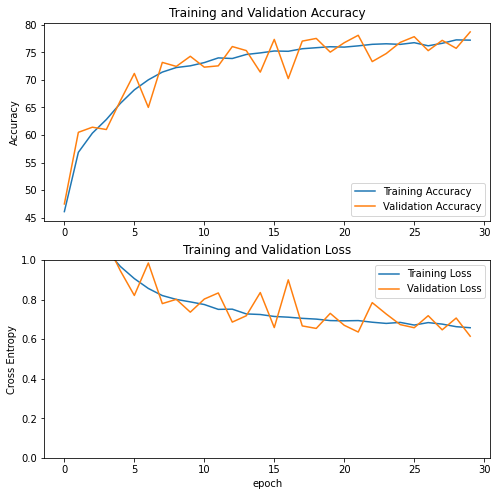

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/tomato.pk1')
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('/kaggle/working/tomato_scripted.pt') # Save

import os 
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'tomato_scripted.pt')

import os 
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'tomato.pk1')

/kaggle/working/tomato.pk1